## AML Project : Polish Bankruptcy Data
*Algorithm : Extreme Machine Learning*

In [1]:
'''Main'''
import pandas as pd
import numpy as np
from scipy.io import arff

'''Data Viz'''
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix,classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

<font color= 'blue'>Loading Datasets</font>


---



In [2]:
# reading the datasets
data_1 = pd.read_excel('year1.xlsx')
data_2 = pd.read_excel('year2.xlsx')
data_3 = pd.read_excel('year3.xlsx')
data_4 = pd.read_excel('year4.xlsx')
data_5 = pd.read_excel('year5.xlsx')

<font color= 'blue'>Preprocessing for ELM</font>


---

We will be using year 1 data to find best value for number of neurons in our model.

In [3]:
df = data_1
df.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr7,Attr8,Attr9,Attr10,Attr11,...,Attr56,Attr57,Attr58,Attr60,Attr61,Attr62,Attr63,Attr64,class,df_year
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.249760,1.33050,1.1389,0.50494,0.249760,...,0.121960,0.39718,0.87804,8.4160,5.1372,82.658,4.4158,7.4277,0,1_year
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.258340,0.99601,1.6996,0.49788,0.261140,...,0.121300,0.42002,0.85300,4.1486,3.2732,107.350,3.4000,60.9870,0,1_year
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.309060,0.43695,1.3090,0.30408,0.312580,...,0.241140,0.81774,0.76599,4.9909,3.9510,134.270,2.7185,5.2078,0,1_year
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.092704,1.86610,1.0571,0.57353,0.092704,...,0.054015,0.14207,0.94598,4.5746,3.6147,86.435,4.2228,5.5497,0,1_year
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.187320,0.63070,1.1559,0.38677,0.187320,...,0.134850,0.48431,0.86515,6.3985,4.3158,127.210,2.8692,7.8980,0,1_year


In [4]:
X = df.drop(['class', 'df_year'], axis = 1)
y = df['class']

sc = pp.StandardScaler()
X = sc.fit_transform(X)

y = y.to_numpy()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42,stratify=y)

<font color = 'blue'> Metric Functions</font>

---



In [6]:
def conf_matrix(y_testset, y_predicted, data_name):
    # Creating Confusion Matrix
    cf_matrix = confusion_matrix(y_testset, y_predicted)

    fig = plt.gcf()
    fig.set_size_inches(9, 6)
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')
    ax.set_title('Confusion Matrix on Test Set');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    plt.show()

    return

In [7]:
def plot_roc_curve(test_y, model_prob, n, axes1, auc):
  
    false_positive_rate, true_positive_rate, thresolds_ = roc_curve(test_y, model_prob)    

    #plt.figure(figsize=(4, 6), dpi=100)
    axes1[n-1].axis('scaled')
    axes1[n-1].set_xlim([0, 1])
    axes1[n-1].set_ylim([0, 1])
    axes1[n-1].plot([0,1], [0,1], linestyle='--',linewidth = 1)
    axes1[n-1].plot(false_positive_rate, true_positive_rate, 'lightblue')  
    axes1[n-1].fill_between(false_positive_rate, true_positive_rate, facecolor='orange', alpha=0.8)
    axes1[n-1].text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, color='black')
    axes1[n-1].set_xlabel("False Positive Rate")
    axes1[n-1].set_ylabel("True Positive Rate")
    axes1[n-1].title.set_text(f'Year{str(n)} - AUC & ROC Curve')

    #plt.show()

    return

In [8]:
def performance_metrics(y_testset, y_predicted):
  
    # Metrics
    accuracy = accuracy_score(y_testset, y_predicted)

    # precision tp / (tp + fp)
    precision = precision_score(y_testset, y_predicted)

    # recall: tp / (tp + fn)
    recall = recall_score(y_testset, y_predicted)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_testset, y_predicted) 
    
    confusion = confusion_matrix(y_testset, y_predicted)

    # AUC
    auc = roc_auc_score(y_testset, y_predicted)
  
    return accuracy, precision, recall, f1, auc, confusion

<font color = 'blue'> Model</font>

---



In [9]:
class ELM(object):  
    
    def __init__(self, inputSize, outputSize, hiddenSize):
        """
        Initialize weight and bias between input layer and hidden layer
        Parameters:
        inputSize(int): The number of input layer dimensions or features in the training data
        outputSize(int): The number of output layer dimensions
        hiddenSize(int): The number of hidden layer dimensions        
        """    

        self.inputSize = inputSize
        self.outputSize = outputSize
        self.hiddenSize = hiddenSize       
        
        # Initialize random weight with range [-0.5, 0.5]
        self.weight = np.matrix(np.random.uniform(-0.5, 0.5, (self.hiddenSize, self.inputSize)))

        # Initialize random bias with range [0, 1]
        self.bias = np.matrix(np.random.uniform(0, 1, (1, self.hiddenSize)))
        
        self.H = 0
        self.beta = 0

    def sigmoid(self, x):
        """
        Sigmoid activation function
        """
        return 1 / (1 + np.exp(-1 * x))

    def predict(self, X):
        """
        Predict the results of the training process using test data
        Parameters:
        X(list):Test data that will be used to determine output using ELM
        Returns:
            Predicted results or outputs from test data
        """
        X = np.matrix(X)
        y = self.sigmoid((X * self.weight.T) + self.bias) * self.beta

        return y

    def train(self, X, y, delta):
        """
        Extreme Learning Machine training process
        Parameters:
        X(list): X Training data
        y(list): y Training data
        Returns:
            The results of the training process   
        """

        X = np.matrix(X)
        y = np.matrix(y)        
        
        # Calculate hidden layer
        self.H = (X * self.weight.T) + self.bias
        
        # Activation function and add delta for improved learning.
        self.H = self.sigmoid(self.H) + delta

        # Moore-Penrose pseudoinverse matrix        
        H_moore_penrose = np.linalg.inv(self.H.T * self.H) * self.H.T

        # Calculate the output weight matrix beta
        self.beta = H_moore_penrose * y

        return self.H * self.beta

In [10]:
def ELM_Model(X_train, X_test, y_train, num_hidden, delta):
    '''
    Function to run ELM Model with given parameters. Returns the prediction results.
    
    Parameters:
        X_train: array-like or matrix
            Training data that contains the value of each feature in train set
        X_test: array-like or matrix
            Training data that contains the value of each feature in test set
        y_train: array-like or matrix
            Training data that contains the value of the target (class) in train set
        Returns:
            The results of the predicted model
    '''
    
    # Train
    elm = ELM(X_train.shape[1], 1, num_hidden)
    elm.train(X_train,y_train.reshape(-1,1),delta)
    
    # Predict
    y_pred = elm.predict(X_test)
    
    return y_pred

In [11]:
# For Best Results in grid search
grid_data = {'Accuracy': 0, "Precision": 0, "Recall": 0, 'F1_score': 0, "confusion" : [], "Neurons":0,"Threshold":0}

In [12]:
thresholds = [float(j) / 100 for j in range(0, 100, 1)]

for i in range(32,1025,4):
    y_pred = ELM_Model(X_train, X_test, y_train, i, 0)
    for j in thresholds:
        y_pred_j = (y_pred > float(j)).astype(int)
        accuracy, precision, recall, f1, auc, confusion = performance_metrics(y_test, y_pred_j)
        
        if f1 > grid_data['F1_score']:
            grid_data['F1_score'] = f1
            grid_data['confusion'] = confusion
            grid_data['Recall'] = recall            
            grid_data['Accuracy'] = accuracy
            grid_data['Precision'] = precision
            grid_data['Neurons'] = i
            grid_data['Threshold'] = j

In [13]:
grid_data

{'Accuracy': 0.9502133712660028,
 'Precision': 0.3,
 'Recall': 0.2222222222222222,
 'F1_score': 0.25531914893617025,
 'confusion': array([[662,  14],
        [ 21,   6]], dtype=int64),
 'Neurons': 76,
 'Threshold': 0.1}

--------

Since we are running a randomized algorithm, there is no particular number of neurons which gives us the best F1 score. After running the grid search multiple times, we have noticed that around 150-250 neurons can give us good results.

Therefore, we will be keeping 256 neurons in hidden layer as our base parameter.

We will further try to find optimal threshold and delta for our Extreme Learning Model.

In [14]:
def grid_search(df,hidden_neurons,threshold_list,delta):
    
    # Seperating the data
    X = df.drop(['class', 'df_year'], axis = 1)
    y = df['class']
    
    # Scaling the data
    sc = pp.StandardScaler()
    X = sc.fit_transform(X)
    y = y.to_numpy()
    
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42,stratify=y)
    
    y_pred = ELM_Model(X_train, X_test, y_train, hidden_neurons, delta)
    
    grid_data = {
                    'Accuracy': 0, "Precision": 0, "Recall": 0, 'F1_score': 0, "confusion" : [],
                     "Threshold":0,"y_pred":None,"y_test":None
            }
    for i in threshold_list:
        y_pred_i = (y_pred > float(i)).astype(int)
        accuracy, precision, recall, f1, auc, confusion = performance_metrics(y_test, y_pred_i)
        if f1 > grid_data['F1_score']:
            grid_data['F1_score'] = f1
            grid_data['confusion'] = confusion
            grid_data['Recall'] = recall            
            grid_data['Accuracy'] = accuracy
            grid_data['AUC'] = auc
            grid_data['Precision'] = precision
            grid_data['Threshold'] = i
            grid_data['y_pred'] = y_pred_i
            grid_data['y_test'] = y_test
            
    return grid_data

In [15]:
# For Summary Results & comparison
plot_data = {'Data_Name':[], 'Accuracy': [], "Precision": [],
             "Recall": [], 'F1_score': [], 'Scale_Type': [], 'AUC':[],
             'Test_size' : [], 'Model' : [], 'Activation' :[] }

<font color = 'blue'>ELM</font>

---



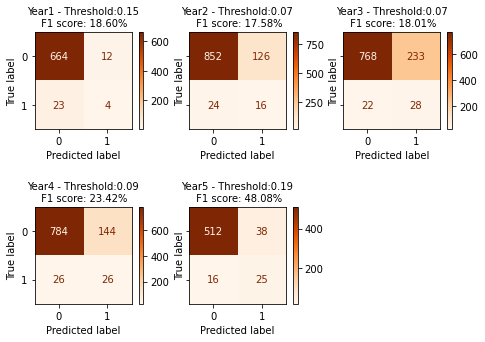

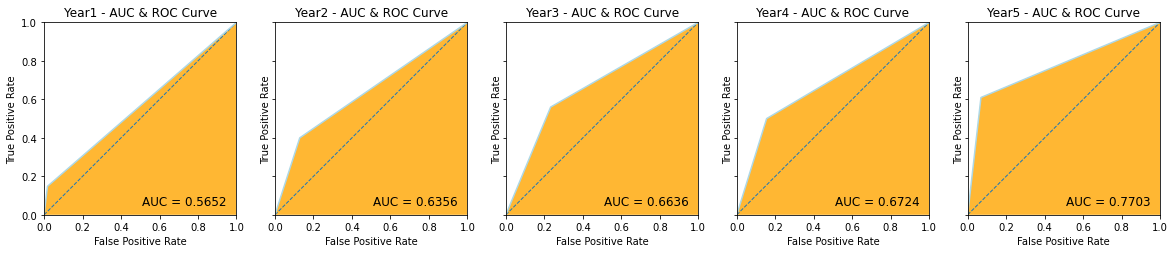

In [16]:
# Input Values

datasets = [data_1, data_2, data_3, data_4, data_5]
thresholds = [float(j) / 100 for j in range(0, 100, 1)]
n = 1

# Initialize variables for graphs
i = 0
f, axes = plt.subplots(2, 3, figsize=(8, 5), sharey='row')
axes = axes.flatten()
f1, axes1 = plt.subplots(1, 5, figsize=(20, 4), sharey='row')

for df in datasets:
    
    data_name = 'Year' + str(n)
    
    # Main Model.
    grid_data = grid_search(df,256,thresholds,0)

    plot_data['Data_Name'].append(data_name)
    plot_data['Accuracy'].append(grid_data['Accuracy'])
    plot_data['Precision'].append(grid_data['Precision'])
    plot_data['Recall'].append(grid_data['Recall'])
    plot_data['F1_score'].append(grid_data['F1_score'])
    plot_data['Scale_Type'].append('StandardScaler')
    plot_data['Test_size'].append("0.1")
    plot_data['Model'].append('ELM') # Change as per model
    plot_data['Activation'].append("sigmoid")
    plot_data['AUC'].append(grid_data['AUC'])
    
    plot_roc_curve(grid_data['y_test'], grid_data['y_pred'], n, axes1, grid_data['AUC'])
    
    cmd = ConfusionMatrixDisplay(grid_data['confusion'])
    cmd.plot(cmap='Oranges', ax=axes[i])
    f1 = grid_data['F1_score']
    t = grid_data['Threshold']
    axes[i].set_title(f'Year{str(n)} - Threshold:{np.round(t,4)}\n F1 score: {f1:.2%}', fontsize = 10)
    axes[5].set_axis_off()
    i+=1
    n+=1
    
f.subplots_adjust(hspace=.8)
f.subplots_adjust(wspace=0.12)
plt.show()

In [17]:
Performance_numbers = pd.DataFrame(plot_data)

In [18]:
Performance_numbers

,Data_Name,Accuracy,Precision,Recall,F1_score,Scale_Type,AUC,Test_size,Model,Activation
0,Year1,0.950213,0.250000,0.148148,0.186047,StandardScaler,0.565198,0.1,ELM,sigmoid
1,Year2,0.852652,0.112676,0.400000,0.175824,StandardScaler,0.635583,0.1,ELM,sigmoid
2,Year3,0.757374,0.107280,0.560000,0.180064,StandardScaler,0.663616,0.1,ELM,sigmoid
3,Year4,0.826531,0.152941,0.500000,0.234234,StandardScaler,0.672414,0.1,ELM,sigmoid
4,Year5,0.908629,0.396825,0.609756,0.480769,StandardScaler,0.770333,0.1,ELM,sigmoid


In [19]:
# Change Filename as per model
Performance_numbers.to_excel('ELM_Results.xlsx', index=False) 

In [20]:
# For Summary Results & comparison
plot_data = {'Data_Name':[], 'Accuracy': [], "Precision": [],
             "Recall": [], 'F1_score': [], 'Scale_Type': [], 'AUC':[],
             'Test_size' : [], 'Model' : [], 'Activation' :[] }

<font color = 'blue'> Enhanced ELM</font>

---



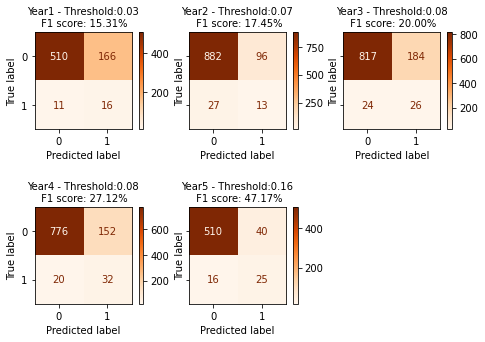

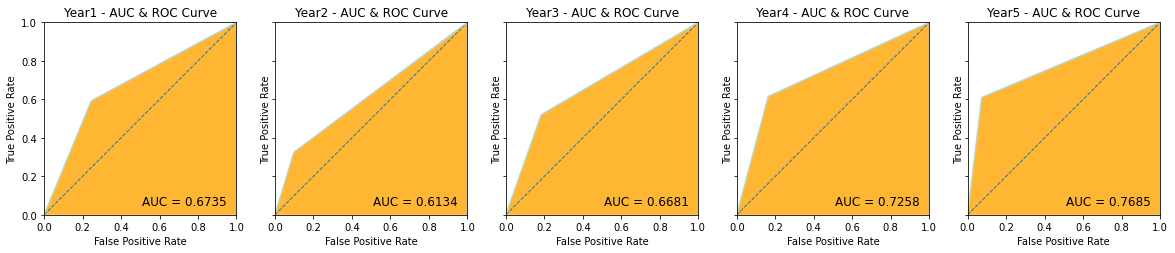

In [21]:
# Input Values

datasets = [data_1, data_2, data_3, data_4, data_5]
thresholds = [float(j) / 100 for j in range(0, 100, 1)]
n = 1

# Initialize variables for graphs
i = 0
f, axes = plt.subplots(2, 3, figsize=(8, 5), sharey='row')
axes = axes.flatten()
f1, axes1 = plt.subplots(1, 5, figsize=(20, 4), sharey='row')

for df in datasets:
    
    data_name = 'Year' + str(n)
    
    # Main Model.
    grid_data = grid_search(df,256,thresholds,0.015)

    plot_data['Data_Name'].append(data_name)
    plot_data['Accuracy'].append(grid_data['Accuracy'])
    plot_data['Precision'].append(grid_data['Precision'])
    plot_data['Recall'].append(grid_data['Recall'])
    plot_data['F1_score'].append(grid_data['F1_score'])
    plot_data['Scale_Type'].append('StandardScaler')
    plot_data['Test_size'].append("0.1")
    plot_data['Model'].append('Enhanced ELM') # Change as per model
    plot_data['Activation'].append("sigmoid")
    plot_data['AUC'].append(grid_data['AUC'])
    
    plot_roc_curve(grid_data['y_test'], grid_data['y_pred'], n, axes1, grid_data['AUC'])
    
    cmd = ConfusionMatrixDisplay(grid_data['confusion'])
    cmd.plot(cmap='Oranges', ax=axes[i])
    f1 = grid_data['F1_score']
    t = grid_data['Threshold']
    axes[i].set_title(f'Year{str(n)} - Threshold:{np.round(t,4)}\n F1 score: {f1:.2%}', fontsize = 10)
    axes[5].set_axis_off()
    i+=1
    n+=1
    
f.subplots_adjust(hspace=.8)
f.subplots_adjust(wspace=0.12)
plt.show()

In [22]:
Performance_numbers = pd.DataFrame(plot_data)

In [23]:
Performance_numbers

,Data_Name,Accuracy,Precision,Recall,F1_score,Scale_Type,AUC,Test_size,Model,Activation
0,Year1,0.748222,0.087912,0.592593,0.153110,StandardScaler,0.673515,0.1,Enhanced ELM,sigmoid
1,Year2,0.879175,0.119266,0.325000,0.174497,StandardScaler,0.613420,0.1,Enhanced ELM,sigmoid
2,Year3,0.802093,0.123810,0.520000,0.200000,StandardScaler,0.668092,0.1,Enhanced ELM,sigmoid
3,Year4,0.824490,0.173913,0.615385,0.271186,StandardScaler,0.725796,0.1,Enhanced ELM,sigmoid
4,Year5,0.905245,0.384615,0.609756,0.471698,StandardScaler,0.768514,0.1,Enhanced ELM,sigmoid


In [24]:
# Change Filename as per model
Performance_numbers.to_excel('Enhanced_ELM_Results.xlsx', index=False) 